# IMPORT LIBRARIES

In [118]:
# Geography
import geocoder
from geopy.geocoders import Nominatim
from uszipcode import SearchEngine

# Web Scraping
from bs4 import BeautifulSoup
import requests

# Data Analysis
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.backends.backend_pdf import PdfPages
import folium # map rendering library
%matplotlib inline

# TOPIC:
# __Miami Neighborhoods Guide__


# THE QUESTION:
# What's the best neighborhood for you in Miami?
- Located on the southern tip of mainland Florida, Miami teems with diverse cultural experiences, artwork, nightlife, and beauty. Living in and exploring Miami can be a total blast if you’re up for some adventure. However, finding the perfect home among roughly numerous Miami neighborhoods and municipalities can feel overwhelming. However, by grouping  together neighborhoods with similar features, I can help you take a shortcut if you know what kind of a place you're looking for, no matter it's a quiet neighborhood with  walkability, or a perfect viewing point with beach access. By showing those groups of neighborhoods on a map with distinct colors, you can see clearly where to look for your perfect stay in Miami.

## Project Target:
For new-comers who visits Miami for the first time, or anyone who wants to have a general concept of how different neighborhoods are distributed in Miami-dade county, and what they are most popular with.

Also for anyone who wants to develop an app that helps people find apartments, hotels and other places to stay in Miami area. This project can help you visulaize the locations and find popular features in your target neighborhoods. 

# GOAL of the project

- Clustering neighborhoods in Miami and explore their features in each cluster
- Visualize neighbirhoods and clusters on Map
- Add rent and population as labels on map for each neighborhoods

# Analytic Approach

CLustering Model: K-means 

# Data Requirements 

- Foursquare data in JSON format for each neighborhood including venue names and catagories.
- Lists of Miami neighborhoods and municipalities in tabular forms that include name and location information.
- Lists of average rent in tabular form for each neighborhood and municipalities.

# Data Collection
Perform data collection and data assessment.

## Part 1: Neighborhoods in city of Miami

In [2]:
#neighbor_list_url = 'http://roofdepotusa.com/municipalities/municipalities_md.htm' 
neighbor_list_url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami'
# the average rent for each neighborhood
rent_url = 'https://www.zumper.com/rent-research/miami-fl'

In [3]:
# Define Foursquare Credentials and Version
CLIENT_ID = '02OO1R2CDPWAUXLGL1UET1EHOMVTHLVDKJDA1M1WM40FUUVR' # your Foursquare ID
CLIENT_SECRET = 'HL3K3KMTPN1QIIC40A10XJLAHO45QZ1VSLNLHDCL05JM0GU3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Get the table of average rent for neighborhoods in Miami

In [4]:
# Scrape the rent table from web
html_string = requests.get(rent_url).text
soup = BeautifulSoup(html_string, 'lxml')
table = soup.find_all('table')[1]

df_rent = pd.DataFrame(columns=['Neighborhood', 'Rent']) 

for row in table.find_all('tr',  {'class': 'NeighborhoodRent_tableBodyRow__2wAkA'}):
    column = {'Neighborhood': row.find_all('td')[0].get_text(), 
              'Rent': row.find_all('td')[1].get_text()}
    df_rent = df_rent.append(column, ignore_index=True)


In [5]:
df_rent

,Neighborhood,Rent
0,Brickell,"$2,050"
1,Coral Way,"$1,650"
2,Edgewater,"$1,909"
3,Little Haiti,"$2,149"
4,Downtown Miami,"$1,800"
5,East Little Havana,"$1,300"
6,Media and Entertainment District,"$1,855"
7,Wynwood,"$1,995"
8,Upper East Side,"$1,575"
9,Northeast Coconut Grove,"$1,463"


### Get the table of Miami neighborhoods

In [6]:
# Scrape the neighborhood list from web
dfs = pd.read_html(neighbor_list_url)
df_neighbors = dfs[0]

In [7]:
print(df_neighbors.shape)
df_neighbors.head(10)

(26, 6)


,Neighborhood,Demonym,Population2010,Population/Km²,Sub-neighborhoods,Coordinates
0,Allapattah,NaN,54289,4401,NaN,25.815-80.224
1,Arts & Entertainment District,NaN,11033,7948,NaN,25.799-80.190
2,Brickell,Brickellite,31759,14541,West Brickell,25.758-80.193
3,Buena Vista,NaN,9058,3540,Buena Vista East Historic District and Design ...,25.813-80.192
4,Coconut Grove,Grovite,20076,3091,"Center Grove, Northeast Coconut Grove, Southwe...",25.712-80.257
5,Coral Way,NaN,35062,4496,"Coral Gate, Golden Pines, Shenandoah, Historic...",25.750-80.283
6,Design District,NaN,3573,3623,NaN,25.813-80.193
7,Downtown,Downtowner,"71,000 (13,635 CBD only)",10613,"Brickell, Central Business District (CBD), Dow...",25.774-80.193
8,Edgewater,NaN,15005,6675,NaN,25.802-80.190
9,Flagami,NaN,50834,5665,"Alameda, Grapeland Heights, and Fairlawn",25.762-80.316


## Part 2: Municipalities in Miami-dade

In [8]:
# Municipalities list
city_list_url = 'http://roofdepotusa.com/municipalities/municipalities_md.htm'
# the average rent for each Municipality
rent_zipcode = 'fy2021-safmrs.xlsx'

### Get the municipalities table

In [9]:
dfs = pd.read_html(city_list_url,skiprows=2,header=3)
df_list = dfs[0]

In [10]:
df_list.head()

,Folio,Municipality,Address,Phone No.,Code,Phone No..1,Call Hrs.,Days,Links,Links.1,Unnamed: 10
0,28,Aventura,19200 W. Country Club Dr.,305-466-8937,33180.0,305-466-8900,8:30-4:00,NaN,http://www.,cityofaventura.co,NaN
1,12,Bal Harbour,665 96 Street,305-865-7525,33154.0,305-866-4633,8:00-4pm,NaN,http://www.,www.balharbourgo,NaN
2,13,Bay Harbor Island,9665 Bay Harbor Terrace,305-993-1786,33154.0,305-993-1786,9:00-5:00,M/W/F,http://www.,bayharborislands.,NaN
3,17,Biscayne Park,640 NE 114 Street,305-893-7490,33161.0,305-899-8000,8:00-2:30,NaN,http://www.,biscaynepark.gov,NaN
4,3,Coral Gables,405 Biltmore Way,305-446-6800,33134.0,305-460-5245,7:30-3:30,NaN,NaN,http://coralgable,NaN


In [11]:
# Only need 'city name' and 'zipcode' in our table
df_cities = df_list[['Municipality', 'Code']]
df_cities.rename(columns={"Code": "Zipcode"}, inplace=True)

C:\Users\hscsh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
df_cities.tail()

,Municipality,Zipcode
31,Sweet Water,33174.0
32,Town Of Cutler Bay,33189.0
33,Virginia Gardens,33166.0
34,West Miami (*),33144.0
35,(*) West Miami's Building Department is manage...,NaN


In [13]:
# Remove last row
df_cities.drop(index=35, inplace=True)
# Update 'West Miami (*)' to 'West Miami'
df_cities.at[34,'Municipality'] = 'West Miami'

C:\Users\hscsh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
# convert zipcode to int
df_cities['Zipcode'] = df_cities['Zipcode'].astype(int)

C:\Users\hscsh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
df_cities.tail()

,Municipality,Zipcode
30,Surfside,33154
31,Sweet Water,33174
32,Town Of Cutler Bay,33189
33,Virginia Gardens,33166
34,West Miami,33144


In [16]:
# Get coordinates from zipcode
def get_coords(code):
    geolocator = Nominatim(user_agent="geoapiExercises")
    zipcode = str(code)
    location = geolocator.geocode(zipcode, country_codes='us')
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

In [17]:
lats, lons =[], []
for code in df_cities['Zipcode'].tolist():
    latitude, longitude = get_coords(code)
    lats.append(latitude)
    lons.append(longitude)
df_cities['Latitudes'] = lats
df_cities['Longitudes'] = lons

C:\Users\hscsh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hscsh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [18]:
df_cities.head()

,Municipality,Zipcode,Latitudes,Longitudes
0,Aventura,33180,25.962897,-80.144402
1,Bal Harbour,33154,25.882990,-80.128078
2,Bay Harbor Island,33154,25.882990,-80.128078
3,Biscayne Park,33161,25.893410,-80.182457
4,Coral Gables,33134,25.755556,-80.270126


### Get rent from zipcode

In [19]:
# read the xlsx file that contains zipcode and rents
df_zipcode_rents = pd.read_excel(rent_zipcode)

In [20]:
print(df_zipcode_rents.shape)
df_zipcode_rents.columns

(27144, 18)


Index(['ZIP\nCode', 'HUD Area Code', 'HUD Metro Fair Market Rent Area Name',
       'SAFMR\n0BR', 'SAFMR\n0BR -\n90%\nPayment\nStandard',
       'SAFMR\n0BR -\n110%\nPayment\nStandard', 'SAFMR\n1BR',
       'SAFMR\n1BR -\n90%\nPayment\nStandard',
       'SAFMR\n1BR -\n110%\nPayment\nStandard', 'SAFMR\n2BR',
       'SAFMR\n2BR -\n90%\nPayment\nStandard',
       'SAFMR\n2BR -\n110%\nPayment\nStandard', 'SAFMR\n3BR',
       'SAFMR\n3BR -\n90%\nPayment\nStandard',
       'SAFMR\n3BR -\n110%\nPayment\nStandard', 'SAFMR\n4BR',
       'SAFMR\n4BR -\n90%\nPayment\nStandard',
       'SAFMR\n4BR -\n110%\nPayment\nStandard'],
      dtype='object')

In [21]:
df_zipcode_rents['ZIP\nCode'] = df_zipcode_rents['ZIP\nCode'].astype(str)
df_zipcode_rents = df_zipcode_rents.set_index('ZIP\nCode')

In [22]:
df_zipcode_rents.head(2)

,HUD Area Code,HUD Metro Fair Market Rent Area Name,SAFMR\n0BR,SAFMR\n0BR -\n90%\nPayment\nStandard,SAFMR\n0BR -\n110%\nPayment\nStandard,SAFMR\n1BR,SAFMR\n1BR -\n90%\nPayment\nStandard,SAFMR\n1BR -\n110%\nPayment\nStandard,SAFMR\n2BR,SAFMR\n2BR -\n90%\nPayment\nStandard,SAFMR\n2BR -\n110%\nPayment\nStandard,SAFMR\n3BR,SAFMR\n3BR -\n90%\nPayment\nStandard,SAFMR\n3BR -\n110%\nPayment\nStandard,SAFMR\n4BR,SAFMR\n4BR -\n90%\nPayment\nStandard,SAFMR\n4BR -\n110%\nPayment\nStandard
ZIP Code,,,,,,,,,,,,,,,,,
601,METRO10380N72141,"Utuado Municipio, PR HUD Metro FMR Area",360,324,396,370,333,407,420,378,462,580,522,638,680,612,748
601,METRO38660M38660,"Ponce, PR HUD Metro FMR Area",360,324,396,370,333,407,420,378,462,580,522,638,680,612,748


In [23]:
# Get rent from xlxs file and append it to the city table df_cities
rents = ['$'+str(df_zipcode_rents.at[str(code), 'SAFMR\n2BR']) for code in df_cities['Zipcode'].tolist()]
df_cities['Rent'] = rents

C:\Users\hscsh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
df_cities.head(2)

,Municipality,Zipcode,Latitudes,Longitudes,Rent
0,Aventura,33180,25.962897,-80.144402,$2310
1,Bal Harbour,33154,25.882990,-80.128078,$2220


### Get population from uszipcode package

In [25]:
work_dir = "D:\\OneDrive - University of Miami\\documents\\IBM\\Applied Data Science Capstone\\"
search = SearchEngine(simple_zipcode=True, db_file_dir=work_dir)
pops = [search.by_zipcode(code).population for code in df_cities['Zipcode']]
df_cities = df_cities.assign(Population=pops)

In [26]:
df_cities

,Municipality,Zipcode,Latitudes,Longitudes,Rent,Population
0,Aventura,33180,25.962897,-80.144402,$2310,30840.0
1,Bal Harbour,33154,25.882990,-80.128078,$2220,13971.0
2,Bay Harbor Island,33154,25.882990,-80.128078,$2220,13971.0
3,Biscayne Park,33161,25.893410,-80.182457,$1470,53710.0
4,Coral Gables,33134,25.755556,-80.270126,$1740,37456.0
5,Doral,33178,25.832296,-80.369946,$2250,39489.0
6,El Portal,33138,25.853388,-80.184637,$1470,27571.0
7,Florida City,33034,25.444053,-80.490368,$1470,18613.0
8,Golden Beach,33160,25.940762,-80.134126,$2050,40053.0
9,Hialeah,33011,38.614324,-75.176024,$1550,NaN


# Data Understanding
Is the data that you collected representative of the problem to be solved?

When people talk about Miami, or the Magic City, they usually refer to Miami-Dade County, which covers City of Miami, Coral Gables, and the famous Miami Beach, and many other surrounding areas. However, finding neighborhoods in Miami-dade county is relately complicated. The county can be divided into a list of Municipalities and Census-designated places, each having their own defination of neighborhoods. Counting all the neighborhood in every municipality would be too much for this project. To make things simpler and clearer, I decide to divide the data into two parts:
- Part 1: Neighborhoods in City of Miami following the defination in this [Wikipedia](https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami) page
- Part 2: Other Municipalities in Miami-dade county, such as Coral Gables, Kendall and Miami Beach.

For each part I construct a dataset including their names, coordinates and find their average rent* accordingly. In the end, I merge those two parts together and in this way I can construct a table containing neighborhood names, locations, populations and average rents for all the neighborhoods in Miami plus all the municipalities in Miami-dade. By using Foursquare data, I can explore and add popular venues in each neighborhood, thus complete the construction of this dataset.
(Rent*: The average rent in this project is calculated for two-bedroom apartments.)

# Data Preparation
Data must be prepared in a way that addresses missing or invalid values and removes duplicates, toward ensuring that everything is properly formatted.

## Modify neighborhood table

In [27]:
# Remove unneccessary columns: 'Demonym', 'Population/Km²', and 'Sub-neighborhoods' 
df_neighbors = df_neighbors.drop(['Demonym', 'Population/Km²', 'Sub-neighborhoods'], axis=1)

In [28]:
# remove last row, which is the row for the whole Miami area.
df_neighbors = df_neighbors.drop(df_neighbors.index[-1])

In [29]:
# convert 'Coordinates' column to 'Latitudes' and 'Longitudes'
lats = [float(coord.split('-')[0]) if type(coord) == str else float('Nan') for coord in df_neighbors['Coordinates']]
lons = [-float(coord.split('-')[1]) if type(coord) == str else float('Nan') for coord in df_neighbors['Coordinates']]

df_neighbors['Latitudes'] = lats
df_neighbors['Longitudes'] = lons
df_neighbors = df_neighbors.drop(['Coordinates'], axis=1)

In [30]:
df_neighbors

,Neighborhood,Population2010,Latitudes,Longitudes
0,Allapattah,54289,25.815,-80.224
1,Arts & Entertainment District,11033,25.799,-80.190
2,Brickell,31759,25.758,-80.193
3,Buena Vista,9058,25.813,-80.192
4,Coconut Grove,20076,25.712,-80.257
5,Coral Way,35062,25.750,-80.283
6,Design District,3573,25.813,-80.193
7,Downtown,"71,000 (13,635 CBD only)",25.774,-80.193
8,Edgewater,15005,25.802,-80.190
9,Flagami,50834,25.762,-80.316


In [31]:
# remove rows with no coordinates info
df_neighbors = df_neighbors.drop(df_neighbors.index[11])
# Change Downtown population to pure number format
df_neighbors.at[7, 'Population2010'] = 71000
# Change Midtown population to Nan
index = df_neighbors.index[df_neighbors['Neighborhood'] == 'Midtown']
df_neighbors.at[index, 'Population2010'] = float('Nan')

In [32]:
# rename Population2010 as Population
df_neighbors.rename(columns={"Population2010": "Population"}, inplace=True)

In [33]:
df_neighbors

,Neighborhood,Population,Latitudes,Longitudes
0,Allapattah,54289,25.815,-80.224
1,Arts & Entertainment District,11033,25.799,-80.190
2,Brickell,31759,25.758,-80.193
3,Buena Vista,9058,25.813,-80.192
4,Coconut Grove,20076,25.712,-80.257
5,Coral Way,35062,25.750,-80.283
6,Design District,3573,25.813,-80.193
7,Downtown,71000,25.774,-80.193
8,Edgewater,15005,25.802,-80.190
9,Flagami,50834,25.762,-80.316


## Modify Rent table

In [34]:
# check which neighborhood from df_neighbors is not present in df_rent
for name in df_neighbors['Neighborhood']:
    if name not in df_rent['Neighborhood'].tolist():
        print(name)

Arts & Entertainment District
Buena Vista
Coconut Grove
Design District
Downtown
Grapeland Heights
Little Havana
Lummus Park
Midtown
The Roads
Upper Eastside
Venetian Islands
Virginia Key
West Flagler


In [35]:
df_rent

,Neighborhood,Rent
0,Brickell,"$2,050"
1,Coral Way,"$1,650"
2,Edgewater,"$1,909"
3,Little Haiti,"$2,149"
4,Downtown Miami,"$1,800"
5,East Little Havana,"$1,300"
6,Media and Entertainment District,"$1,855"
7,Wynwood,"$1,995"
8,Upper East Side,"$1,575"
9,Northeast Coconut Grove,"$1,463"


In [36]:
# Make the neighborhood names the same as the neighborhood table
df_rent.at[4, 'Neighborhood'] = 'Downtown'
df_rent.at[6, 'Neighborhood'] = 'Arts & Entertainment District'
df_rent.at[8, 'Neighborhood'] = 'Upper Eastside'

def rent_average(x ,y):
    x = int(x.replace('$','').replace(',',''))
    y = int(y.replace('$','').replace(',',''))
    average = (x+y)/2
    return '$' + str(average)[0] + ',' + str(average)[1:-2]

new_row1 = {'Neighborhood': 'Coconut Grove', 'Rent': rent_average(df_rent.at[9,'Rent'], df_rent.at[17,'Rent'])}
new_row2 = {'Neighborhood': 'Little Havana', 'Rent': rent_average(df_rent.at[5,'Rent'], df_rent.at[10,'Rent'])}

df_rent = df_rent.append(new_row1, ignore_index=True)
df_rent = df_rent.append(new_row2, ignore_index=True)

In [37]:
df_rent

,Neighborhood,Rent
0,Brickell,"$2,050"
1,Coral Way,"$1,650"
2,Edgewater,"$1,909"
3,Little Haiti,"$2,149"
4,Downtown,"$1,800"
5,East Little Havana,"$1,300"
6,Arts & Entertainment District,"$1,855"
7,Wynwood,"$1,995"
8,Upper Eastside,"$1,575"
9,Northeast Coconut Grove,"$1,463"


## Merge neighborhood table and neighborhood rent table

In [38]:
# Here we join df_neighbors and df_rent based on 'Neighborhood' column.
df_merged = df_neighbors.join(df_rent.set_index('Neighborhood'), on='Neighborhood', how = 'left')

In [39]:
print(df_merged.shape)
df_merged

(24, 5)


,Neighborhood,Population,Latitudes,Longitudes,Rent
0,Allapattah,54289,25.815,-80.224,"$1,555"
1,Arts & Entertainment District,11033,25.799,-80.190,"$1,855"
2,Brickell,31759,25.758,-80.193,"$2,050"
3,Buena Vista,9058,25.813,-80.192,NaN
4,Coconut Grove,20076,25.712,-80.257,"$1,456"
5,Coral Way,35062,25.750,-80.283,"$1,650"
6,Design District,3573,25.813,-80.193,NaN
7,Downtown,71000,25.774,-80.193,"$1,800"
8,Edgewater,15005,25.802,-80.190,"$1,909"
9,Flagami,50834,25.762,-80.316,"$1,375"


## Modify Municipality table 

In [40]:
# check and remove rows with the same zipcode
# come back and re-check after removing the duplicates
df_cities['Zipcode'].value_counts()

33154    4
33178    2
33160    2
33138    2
33161    2
33166    2
33156    1
33157    1
33030    1
33034    1
33169    1
33109    1
33174    1
33175    1
33149    1
33016    1
33054    1
33189    1
33144    1
33130    1
33162    1
33134    1
33011    1
33141    1
33014    1
33143    1
33180    1
Name: Zipcode, dtype: int64

In [41]:
# it seems we have 4 duplicates for 33154, 2 for 33178, 33160, 33161, 33166.
# let's print them out
for code in [33154, 33178, 33160, 33161, 33166, 33138]:
    for i in range(len(df_cities)):
        if df_cities.at[i, 'Zipcode'] == code:
            print(code, df_cities.at[i, 'Municipality'], sep=':')

33154:Bal Harbour
33154:Bay Harbor Island
33154:Indian Creek
33154:Surfside
33178:Doral
33178:Medley
33160:Golden Beach
33160:Sunny-Isles Beach
33161:Biscayne Park
33161:North Miami
33166:Miami Springs
33166:Virginia Gardens
33138:El Portal
33138:Miami Shores


In [42]:
# remove duplicates
bad_names = ['Bay Harbor Island', 'Indian Creek', 'Surfside', 'Medley', 'Sunny-Isles Beach', 'Biscayne Park', 'Virginia Gardens', 'El Portal']
for name in bad_names:
    df_cities.drop(df_cities[df_cities['Municipality'] == name].index, inplace = True)

In [43]:
df_cities

,Municipality,Zipcode,Latitudes,Longitudes,Rent,Population
0,Aventura,33180,25.962897,-80.144402,$2310,30840.0
1,Bal Harbour,33154,25.882990,-80.128078,$2220,13971.0
4,Coral Gables,33134,25.755556,-80.270126,$1740,37456.0
5,Doral,33178,25.832296,-80.369946,$2250,39489.0
7,Florida City,33034,25.444053,-80.490368,$1470,18613.0
8,Golden Beach,33160,25.940762,-80.134126,$2050,40053.0
9,Hialeah,33011,38.614324,-75.176024,$1550,NaN
10,Hialeah Gardens,33016,25.892396,-80.332956,$1570,45342.0
11,Homestead,33030,25.481019,-80.488113,$1470,34110.0
13,Key Biscayne,33149,25.692111,-80.166535,$2330,12389.0


In [44]:
# drop the zipcode column
df_city = df_cities.drop(columns=['Zipcode'])

In [45]:
# rename Municipality column
df_city = df_city.rename(columns={"Municipality": "Neighborhood"})

In [46]:
df_city.head(2)

,Neighborhood,Latitudes,Longitudes,Rent,Population
0,Aventura,25.962897,-80.144402,$2310,30840.0
1,Bal Harbour,25.882990,-80.128078,$2220,13971.0


## Merge neighborhood table and Municipality table

In [47]:
df_merged = pd.concat([df_merged, df_city], axis=0)

In [48]:
# reset index
df_merged = df_merged.reset_index(drop=True)

In [49]:
df_merged

,Neighborhood,Population,Latitudes,Longitudes,Rent
0,Allapattah,54289,25.815000,-80.224000,"$1,555"
1,Arts & Entertainment District,11033,25.799000,-80.190000,"$1,855"
2,Brickell,31759,25.758000,-80.193000,"$2,050"
3,Buena Vista,9058,25.813000,-80.192000,NaN
4,Coconut Grove,20076,25.712000,-80.257000,"$1,456"
5,Coral Way,35062,25.750000,-80.283000,"$1,650"
6,Design District,3573,25.813000,-80.193000,NaN
7,Downtown,71000,25.774000,-80.193000,"$1,800"
8,Edgewater,15005,25.802000,-80.190000,"$1,909"
9,Flagami,50834,25.762000,-80.316000,"$1,375"


## Create a map of Miami with neighborhoods superimposed on top.

In [50]:
# create map of Miami using Miami's latitude and longitude values
latitude = 25.7617
longitude = -80.1918
map_miami = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, rent, pop in zip(df_merged['Latitudes'], df_merged['Longitudes'], df_merged['Neighborhood'], df_merged['Rent'], df_merged['Population']):
    label = """{}:
                (Rent: {})
                (Population: {})""".format(neighborhood, rent, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_miami)  
    
map_miami

## Define a function that gets all the venues in a neighborhood

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, sep=':')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            #code,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [#'Postal Code',
                  'Neighborhood', 
                  'Latitudes', 
                  'Longitudes', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Create a new dataframe that contains all venues

In [52]:
df_venues = getNearbyVenues(names=df_merged['Neighborhood'],
                                   latitudes=df_merged['Latitudes'],
                                   longitudes=df_merged['Longitudes']
                                  )

Allapattah
Arts & Entertainment District
Brickell
Buena Vista
Coconut Grove
Coral Way
Design District
Downtown
Edgewater
Flagami
Grapeland Heights
Liberty City
Little Haiti
Little Havana
Lummus Park
Midtown
Overtown
Park West
The Roads
Upper Eastside
Venetian Islands
Virginia Key
West Flagler
Wynwood
Aventura
Bal Harbour
Coral Gables
Doral
Florida City
Golden Beach
Hialeah
Hialeah Gardens
Homestead
Key Biscayne
Miami
Miami Beach
Miami Gardens
Miami Lakes
Miami Shores
Miami Springs
Miami-Dade County
North Bay Village
North Miami
North Miami Beach
Opa-Locka
Palmetto Bay
Pinecrest
South Miami
Sweet Water
Town Of Cutler Bay
West Miami


In [53]:
# check the size of df_venues
print(df_venues.shape)
df_venues.head()

(4105, 7)


,Neighborhood,Latitudes,Longitudes,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allapattah,25.815,-80.224,Club Tipico Dominicano,25.809557,-80.218593,Nightclub
1,Allapattah,25.815,-80.224,Plaza Seafood Market,25.805638,-80.223992,Seafood Restaurant
2,Allapattah,25.815,-80.224,Snappers Fish & Chicken,25.824110,-80.224870,Seafood Restaurant
3,Allapattah,25.815,-80.224,Papo Llega y Pon,25.803466,-80.223886,Cuban Restaurant
4,Allapattah,25.815,-80.224,Moore Park,25.810316,-80.209683,Park


## Let's check how many venues were returned for each neighborhood

In [54]:
df_venues.groupby('Neighborhood').count()

,Latitudes,Longitudes,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allapattah,51,51,51,51,51,51
Arts & Entertainment District,100,100,100,100,100,100
Aventura,100,100,100,100,100,100
Bal Harbour,66,66,66,66,66,66
Brickell,100,100,100,100,100,100
Buena Vista,100,100,100,100,100,100
Coconut Grove,51,51,51,51,51,51
Coral Gables,100,100,100,100,100,100
Coral Way,86,86,86,86,86,86


In [55]:
print('There are {} uniques venue categories.'.format(len(df_venues['Venue Category'].unique())))

There are 283 uniques venue categories.


In [56]:
df_venues[df_venues['Neighborhood'] == 'Homestead']

,Neighborhood,Latitudes,Longitudes,Venue,Venue Latitude,Venue Longitude,Venue Category
2758,Homestead,25.481019,-80.488113,La Michoacana,25.473314,-80.476500,Ice Cream Shop
2759,Homestead,25.481019,-80.488113,Royal Palm Grill,25.477358,-80.477618,American Restaurant
2760,Homestead,25.481019,-80.488113,Chefs On The Run,25.469902,-80.477057,Restaurant
2761,Homestead,25.481019,-80.488113,White Lion Cafe,25.476092,-80.480437,American Restaurant
2762,Homestead,25.481019,-80.488113,La Pasadita,25.475870,-80.475562,Mexican Restaurant
2763,Homestead,25.481019,-80.488113,Royal Palm Grill,25.474289,-80.477622,American Restaurant
2764,Homestead,25.481019,-80.488113,Soriano Brothers,25.484240,-80.475575,Cuban Restaurant
2765,Homestead,25.481019,-80.488113,La Quebradita Restaurant,25.476408,-80.477720,Mexican Restaurant
2766,Homestead,25.481019,-80.488113,Mexico Marketplace,25.473574,-80.475162,Grocery Store
2767,Homestead,25.481019,-80.488113,El Toro Taco Restaurant,25.469771,-80.477252,Mexican Restaurant


## Analyze Each Neighborhood

In [57]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot.insert(0, 'Neighborhood_Name', df_venues['Neighborhood'])

print('(rows, columns):',df_onehot.shape)
df_onehot.head(10)

(rows, columns): (4105, 284)


,Neighborhood_Name,ATM,Accessories Store,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Warehouse Store,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Allapattah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Allapattah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Allapattah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Allapattah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Allapattah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Allapattah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Allapattah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Allapattah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Allapattah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Allapattah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [58]:
df_grouped = df_onehot.groupby('Neighborhood_Name').mean().reset_index()
df_grouped.head(10)

,Neighborhood_Name,ATM,Accessories Store,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Warehouse Store,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Allapattah,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.0
1,Arts & Entertainment District,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.00,0.01,...,0.0,0.0,0.010000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.0
2,Aventura,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.01,0.000000,0.0,0.020000,0.00,0.0,0.0
3,Bal Harbour,0.0,0.0,0.0,0.0,0.015152,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.00,0.000000,0.0,0.015152,0.00,0.0,0.0
4,Brickell,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.01,0.000000,0.0,0.000000,0.02,0.0,0.0
5,Buena Vista,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.01,0.01,...,0.0,0.0,0.010000,0.00,0.000000,0.0,0.010000,0.00,0.0,0.0
6,Coconut Grove,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.00,0.00,...,0.0,0.0,0.019608,0.00,0.000000,0.0,0.000000,0.00,0.0,0.0
7,Coral Gables,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.0,0.0
8,Coral Way,0.0,0.0,0.0,0.0,0.011628,0.0,0.0,0.00,0.00,...,0.0,0.0,0.000000,0.00,0.011628,0.0,0.011628,0.00,0.0,0.0
9,Design District,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.01,0.01,...,0.0,0.0,0.010000,0.00,0.000000,0.0,0.010000,0.00,0.0,0.0


## Find the top 10 most common venues for each neighborhood

In [59]:
def return_most_common_venues(row, num_top_venues):
    """
    This function sorts the venues in descending order
    """
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### create the new dataframe and display the top 10 venues for each neighborhood.

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df_grouped['Neighborhood_Name']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allapattah,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Seafood Restaurant,Nightclub,Park,Sandwich Place,Discount Store,Restaurant,Storage Facility
1,Arts & Entertainment District,Art Gallery,Ice Cream Shop,Coffee Shop,Restaurant,Bar,Beer Garden,Asian Restaurant,Pizza Place,Mexican Restaurant,Food Truck
2,Aventura,Clothing Store,Cosmetics Shop,Department Store,Italian Restaurant,Grocery Store,Furniture / Home Store,American Restaurant,Hotel,Electronics Store,Coffee Shop
3,Bal Harbour,Beach,Hotel,Boutique,Italian Restaurant,Grocery Store,Deli / Bodega,Resort,Coffee Shop,Café,Shoe Store
4,Brickell,Hotel,Italian Restaurant,Bar,Argentinian Restaurant,Seafood Restaurant,Lounge,Japanese Restaurant,Steakhouse,American Restaurant,Bakery
5,Buena Vista,Art Gallery,Ice Cream Shop,Coffee Shop,Italian Restaurant,Café,Restaurant,Pizza Place,Gym / Fitness Center,Asian Restaurant,Furniture / Home Store
6,Coconut Grove,American Restaurant,Garden,Bakery,Furniture / Home Store,Coffee Shop,Park,Convenience Store,Spa,Sushi Restaurant,College Cafeteria
7,Coral Gables,Café,Hotel,Italian Restaurant,Grocery Store,Cuban Restaurant,Coffee Shop,Steakhouse,Bakery,Restaurant,Spanish Restaurant
8,Coral Way,Pharmacy,Café,Golf Course,Cuban Restaurant,Pool,Bakery,Tennis Stadium,Tennis Court,Intersection,Spanish Restaurant
9,Design District,Art Gallery,Ice Cream Shop,Coffee Shop,Pizza Place,Café,Italian Restaurant,Restaurant,Gym / Fitness Center,Boutique,Cosmetics Shop


In [61]:
neighborhoods_venues_sorted.shape

(51, 11)

# Data Modelling
These models are based on the analytic approach that was taken, either statistically driven or machine learning driven.

## Run k-means to cluster the neighborhood into 5 clusters.

In [62]:
# set number of clusters
kclusters = 5

df_grouped_clustering = df_grouped.drop('Neighborhood_Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([22,  5,  7, 16,  1], dtype=int64))

## Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [63]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#df_merged = df_toronto

# merge df_grouped with df_venues to add latitude/longitude for each neighborhood
df = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [64]:
df.sort_values(by=['Cluster Labels'])

,Neighborhood,Population,Latitudes,Longitudes,Rent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allapattah,54289,25.815000,-80.224000,"$1,555",0,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Seafood Restaurant,Nightclub,Park,Sandwich Place,Discount Store,Restaurant,Storage Facility
48,Sweet Water,32524,25.762851,-80.358386,$1560,0,Latin American Restaurant,Pharmacy,Pizza Place,Bakery,Coffee Shop,Burger Joint,Fast Food Restaurant,Grocery Store,Sandwich Place,Discount Store
46,Pinecrest,31315,25.667423,-80.307633,$1980,0,Pharmacy,Cosmetics Shop,Bank,Coffee Shop,Pizza Place,Jewelry Store,Auto Dealership,Seafood Restaurant,Bakery,Sushi Restaurant
45,Palmetto Bay,63226,25.606533,-80.349050,$1470,0,Pizza Place,Sandwich Place,Fast Food Restaurant,Caribbean Restaurant,Burger Joint,Grocery Store,Rental Car Location,Dog Run,Shoe Store,Seafood Restaurant
44,Opa-Locka,29061,25.911376,-80.246041,$1470,0,Discount Store,Sandwich Place,Gym,Soccer Field,Pharmacy,Donut Shop,Restaurant,Pizza Place,Fried Chicken Joint,Seafood Restaurant
43,North Miami Beach,43539,25.928899,-80.178542,$1470,0,Fast Food Restaurant,Pharmacy,Pizza Place,Chinese Restaurant,Grocery Store,Sandwich Place,Bank,Peruvian Restaurant,Bakery,Breakfast Spot
42,North Miami,53710,25.893410,-80.182457,$1470,0,Pizza Place,Discount Store,Sandwich Place,Pet Store,Pharmacy,Bank,Cosmetics Shop,Fast Food Restaurant,Convenience Store,Food
40,Miami-Dade County,53206,25.733571,-80.410150,$1850,0,Cuban Restaurant,Latin American Restaurant,Pharmacy,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Sushi Restaurant,Bakery,Sandwich Place,Basketball Court
39,Miami Springs,23038,25.822927,-80.304878,$1640,0,Park,Fast Food Restaurant,Convenience Store,Pizza Place,South American Restaurant,Intersection,Golf Course,Cuban Restaurant,Hotel,Brewery
37,Miami Lakes,40654,25.900032,-80.307097,$1630,0,Pizza Place,Fast Food Restaurant,Italian Restaurant,Pharmacy,Bank,Coffee Shop,Sandwich Place,Bakery,Gas Station,Grocery Store


## Visualize the resulting clusters

In [65]:
# create map of Miami using Miami's latitude and longitude values
latitude = 25.7617
longitude = -80.1918
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbor, cluster, rent, pop in zip(df['Latitudes'], df['Longitudes'], df['Neighborhood'], df['Cluster Labels'], df['Rent'], df['Population']):
    label = folium.Popup("{}: (Rent: {}) (Population: {})".format(neighbor, rent, pop), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #popup=label).add_to(map_clusters)
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [66]:
# Add a legend to map
for i in range(5):
    print(f'{i}:{rainbow[int(i)-1]}')

0:#ff0000
1:#8000ff
2:#00b5eb
3:#80ffb4
4:#ffb360


In [67]:
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Tags:</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#ff0000;opacity:0.7;'></span>Food, Park, Shop</li>
    <li><span style='background:#8000ff;opacity:0.7;'></span>Fast Food, Utilities, Entertainment</li>
    <li><span style='background:#00b5eb;opacity:0.7;'></span>Beach, Resturants, Hotels</li>
    <li><span style='background:#80ffb4;opacity:0.7;'></span>Beach Park, Dog-friendly, Bike Trails</li>
    <li><span style='background:#ffb360;opacity:0.7;'></span>Inland, Fast food, Convenience</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map_clusters.get_root().add_child(macro)

map_clusters


## Examine Clusters

### Cluster 1 

In [68]:
df_1 = df.loc[df['Cluster Labels'] == 0, df.columns[[0,1,4] + list(range(6, df.shape[1]))]]

In [69]:
df_1

,Neighborhood,Population,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allapattah,54289,"$1,555",Fast Food Restaurant,Fried Chicken Joint,Gas Station,Seafood Restaurant,Nightclub,Park,Sandwich Place,Discount Store,Restaurant,Storage Facility
5,Coral Way,35062,"$1,650",Pharmacy,Café,Golf Course,Cuban Restaurant,Pool,Bakery,Tennis Stadium,Tennis Court,Intersection,Spanish Restaurant
9,Flagami,50834,"$1,375",Cuban Restaurant,Fast Food Restaurant,Sandwich Place,Video Game Store,Bakery,Coffee Shop,Hotel,Chinese Restaurant,Pizza Place,Latin American Restaurant
10,Grapeland Heights,14004,NaN,Hotel,Rental Car Location,Airport Service,Cuban Restaurant,Fast Food Restaurant,Coffee Shop,Latin American Restaurant,South American Restaurant,Duty-free Shop,Bank
11,Liberty City,19725,"$1,075",Fried Chicken Joint,Fast Food Restaurant,Discount Store,Park,Sandwich Place,Home Service,Wings Joint,Grocery Store,Seafood Restaurant,Shoe Store
13,Little Havana,76163,"$1,285",Latin American Restaurant,Cuban Restaurant,Seafood Restaurant,Mexican Restaurant,Smoke Shop,Bakery,Bar,Pizza Place,Spanish Restaurant,Coffee Shop
22,West Flagler,31407,NaN,Latin American Restaurant,Bakery,Cuban Restaurant,Pizza Place,Mexican Restaurant,Grocery Store,Fast Food Restaurant,Italian Restaurant,Bank,Theater
27,Doral,39489,$2250,Park,Sandwich Place,Latin American Restaurant,Restaurant,Grocery Store,Department Store,Coffee Shop,Arepa Restaurant,South American Restaurant,Gym
31,Hialeah Gardens,45342,$1570,Pizza Place,Fast Food Restaurant,Grocery Store,Pharmacy,Latin American Restaurant,Sandwich Place,Cuban Restaurant,Gas Station,Bakery,Mobile Phone Shop
32,Homestead,34110,$1470,Mexican Restaurant,Grocery Store,American Restaurant,Fast Food Restaurant,Steakhouse,Big Box Store,Park,Sandwich Place,Gas Station,Garden Center


In [70]:
# Let's get the top 10 venues in this cluster
# convert dataframe to list
venues = []
for col in df_1.columns:
    if 'Venue' in col:
        venues += df_1[col].tolist()
# convert list to series
s_1 = pd.Series(venues)
# sort series by frequency
s_1.value_counts()

Fast Food Restaurant    16
Sandwich Place          16
Pizza Place             16
Bakery                  11
Pharmacy                11
                        ..
Brewery                  1
Arepa Restaurant         1
Pool                     1
Peruvian Restaurant      1
American Restaurant      1
Length: 69, dtype: int64

#### Result for Cluster1:
This cluster represents neighborhoods most popular for food places, with other entertainment facilities and shopping places. You can find many resuturants from different countries, such as Italian, Mexican and Asian resuturants. If you're looing for a place to stay where you can easily find a decent resturant to dine, and maybe go for a walk afterwards, or simply spend some moneny in a shopping mall, you should look into these neighborhoods.
#### Tags:
- Food
- Park
- Shop

### Cluster 2

In [71]:
df_2 = df.loc[df['Cluster Labels'] == 1, df.columns[[0,1,4] + list(range(6, df.shape[1]))]]

In [72]:
df_2

,Neighborhood,Population,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Bal Harbour,13971,$2220,Beach,Hotel,Boutique,Italian Restaurant,Grocery Store,Deli / Bodega,Resort,Coffee Shop,Café,Shoe Store
30,Hialeah,NaN,$1550,Pizza Place,American Restaurant,Beach,Seafood Restaurant,Video Store,Bar,Gift Shop,Golf Course,Sandwich Place,Gym / Fitness Center
33,Key Biscayne,12389,$2330,Beach,Harbor / Marina,Italian Restaurant,Argentinian Restaurant,Bar,Bakery,Coffee Shop,Restaurant,Boat or Ferry,Park
35,Miami Beach,594,$2330,Seafood Restaurant,Hotel,Beach,Italian Restaurant,Park,Steakhouse,Restaurant,Juice Bar,Bar,American Restaurant
41,North Bay Village,35249,$1750,Beach,Hotel,Pizza Place,Coffee Shop,Italian Restaurant,Breakfast Spot,Cuban Restaurant,Restaurant,Brazilian Restaurant,Park


In [73]:
# Let's get the top 10 venues in this cluster
# convert dataframe to list
venues = []
for col in df_2.columns:
    if 'Venue' in col:
        venues += df_2[col].tolist()
# convert list to series
s_2 = pd.Series(venues)
# sort series by frequency
s_2.value_counts()

Beach                     5
Italian Restaurant        4
Restaurant                3
Coffee Shop               3
Park                      3
Hotel                     3
Bar                       3
American Restaurant       2
Seafood Restaurant        2
Pizza Place               2
Grocery Store             1
Deli / Bodega             1
Juice Bar                 1
Boutique                  1
Boat or Ferry             1
Video Store               1
Shoe Store                1
Steakhouse                1
Gift Shop                 1
Resort                    1
Sandwich Place            1
Argentinian Restaurant    1
Bakery                    1
Brazilian Restaurant      1
Golf Course               1
Cuban Restaurant          1
Café                      1
Breakfast Spot            1
Harbor / Marina           1
Gym / Fitness Center      1
dtype: int64

#### Result for Cluster2:
Fast food and discount store are most popular in this cluster, together with utililties like gas station, grocery store, soccer field, phone shop, etc. These neighborhoods are perfect for people who seek a convenient, fast-paced life style. You can easily grab a quick sandwish for dinner, or if you want to cook, the nearby grocery stores are at your service. You can also easily find nightclubs if you want to enjoy your night lives.  
#### Tags:
- Fast Food
- Utilities
- Entertainment

### Cluster 3

In [74]:
df_3 = df.loc[df['Cluster Labels'] == 2, df.columns[[0,1,4] + list(range(6, df.shape[1]))]]

In [75]:
df_3

,Neighborhood,Population,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Arts & Entertainment District,11033,"$1,855",Art Gallery,Ice Cream Shop,Coffee Shop,Restaurant,Bar,Beer Garden,Asian Restaurant,Pizza Place,Mexican Restaurant,Food Truck
3,Buena Vista,9058,NaN,Art Gallery,Ice Cream Shop,Coffee Shop,Italian Restaurant,Café,Restaurant,Pizza Place,Gym / Fitness Center,Asian Restaurant,Furniture / Home Store
6,Design District,3573,NaN,Art Gallery,Ice Cream Shop,Coffee Shop,Pizza Place,Café,Italian Restaurant,Restaurant,Gym / Fitness Center,Boutique,Cosmetics Shop
8,Edgewater,15005,"$1,909",Ice Cream Shop,Art Gallery,Coffee Shop,Restaurant,Bar,Beer Garden,Mexican Restaurant,Pizza Place,Asian Restaurant,Juice Bar
15,Midtown,NaN,NaN,Art Gallery,Ice Cream Shop,Coffee Shop,Restaurant,Pizza Place,Boutique,Bar,Gym / Fitness Center,Café,Mexican Restaurant
16,Overtown,6736,"$1,200",Art Gallery,Ice Cream Shop,Bar,American Restaurant,Brewery,Mexican Restaurant,Restaurant,Beer Garden,Café,Pizza Place
23,Wynwood,7277,"$1,995",Art Gallery,Ice Cream Shop,Restaurant,Bar,Asian Restaurant,Coffee Shop,Beer Garden,Italian Restaurant,Sandwich Place,Mexican Restaurant


In [76]:
# Let's get the top 10 venues in this cluster
# convert dataframe to list
venues = []
for col in df_3.columns:
    if 'Venue' in col:
        venues += df_3[col].tolist()
# convert list to series
s_3 = pd.Series(venues)
# sort series by frequency
s_3_counts = s_3.value_counts().to_frame()
s_3_counts.head(20)

,0
Ice Cream Shop,7
Art Gallery,7
Restaurant,7
Coffee Shop,6
Pizza Place,6
Mexican Restaurant,5
Bar,5
Asian Restaurant,4
Beer Garden,4
Café,4


#### Result for Cluster3:
If you want to live close to the sea, look no further! These neighborhoods are located along the Miami beach shore line, with a beautiful view of the Pacific Ocean. No matter if you want to spend your afternoons on the popular Miami North Beach and South Beach, or look for a small island and enjoy a quiet, private sea view, these neighborhoods can offer you the oppotunities. Also, international resuturants and recreation facilities are all over the place. And great hotels are very easy to find in this area. If you come to Miami for the sunshine and beach, these are the neighborhoods for you!
#### Tags:
- Beach
- Resturants
- Hotels

### Cluster 4

In [77]:
df_4 = df.loc[df['Cluster Labels'] == 3, df.columns[[0,1,4] + list(range(6, df.shape[1]))]]

In [78]:
df_4

,Neighborhood,Population,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Brickell,31759,"$2,050",Hotel,Italian Restaurant,Bar,Argentinian Restaurant,Seafood Restaurant,Lounge,Japanese Restaurant,Steakhouse,American Restaurant,Bakery
4,Coconut Grove,20076,"$1,456",American Restaurant,Garden,Bakery,Furniture / Home Store,Coffee Shop,Park,Convenience Store,Spa,Sushi Restaurant,College Cafeteria
7,Downtown,71000,"$1,800",Hotel,Italian Restaurant,Seafood Restaurant,Peruvian Restaurant,American Restaurant,Residential Building (Apartment / Condo),Coffee Shop,Bakery,Cosmetics Shop,Asian Restaurant
12,Little Haiti,29760,"$2,149",Italian Restaurant,Coffee Shop,Café,Pizza Place,American Restaurant,Art Gallery,Gym,Cosmetics Shop,Art Museum,Jewelry Store
14,Lummus Park,3027,NaN,Hotel,Italian Restaurant,Seafood Restaurant,American Restaurant,Peruvian Restaurant,Latin American Restaurant,Grocery Store,Bar,Spanish Restaurant,Nightclub
17,Park West,4655,"$2,025",Seafood Restaurant,American Restaurant,Italian Restaurant,Park,Hotel,Café,Cocktail Bar,Nightclub,Coffee Shop,Burger Joint
18,The Roads,7327,NaN,Hotel,Italian Restaurant,Latin American Restaurant,Bar,Mexican Restaurant,Argentinian Restaurant,Pharmacy,Grocery Store,Cuban Restaurant,Pizza Place
19,Upper Eastside,12525,"$1,575",Italian Restaurant,Café,Gym,Park,Pizza Place,American Restaurant,Art Gallery,Caribbean Restaurant,Argentinian Restaurant,Sushi Restaurant
20,Venetian Islands,NaN,NaN,Boat or Ferry,Gym / Fitness Center,American Restaurant,Bar,Harbor / Marina,Exhibit,Grocery Store,Cruise Ship,Coffee Shop,Park
24,Aventura,30840,$2310,Clothing Store,Cosmetics Shop,Department Store,Italian Restaurant,Grocery Store,Furniture / Home Store,American Restaurant,Hotel,Electronics Store,Coffee Shop


#### Result for Cluster4:
Virginia Key is an 863-acre barrier island on Miami, and it is mainly occupied by the Virginia Key Beach Park. It's also the only Miami-area beach that allows dogs. Nearby rest rooms and a great view of the curving shoreline make this an ideal place for tailgate parties. The Miami Seaquarium is a marine park on Virginia Key that has one of the world's largest collections of marine animals; some 10,000 specimens. A mountain biking park is located on the northern end of Virginia Key.
#### Tags:
- Beach Park
- Dog-friendly
- Bike Trails

### Cluster 5 

In [79]:
df_5 = df.loc[df['Cluster Labels'] == 4, df.columns[[0,1,4] + list(range(6, df.shape[1]))]]

In [80]:
df_5

,Neighborhood,Population,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Virginia Key,14,NaN,Aquarium,Harbor / Marina,Beach,Park,Snack Place,Exhibit,Zoo Exhibit,Boat or Ferry,Surf Spot,Cafeteria


In [81]:
# Let's get the top 10 venues in this cluster
# convert dataframe to list
venues = []
for col in df_5.columns:
    if 'Venue' in col:
        venues += df_5[col].tolist()
# convert list to series
s_5 = pd.Series(venues)
# sort series by frequency
s_5_counts = s_5.value_counts().to_frame()
s_5_counts.head(20)

,0
Snack Place,1
Cafeteria,1
Aquarium,1
Boat or Ferry,1
Park,1
Harbor / Marina,1
Beach,1
Zoo Exhibit,1
Exhibit,1
Surf Spot,1


#### Result for Cluster5:
Neighborhoods in this cluster are located more inland than those in cluster 3. If you do not want to live too close to the sea, you can look into this cluster. Full of fast food places, grocery stores and other facillities, these neighborhoods are what most common people with a mordern life style would choose. After working a whole day, you can go to your favorite resturant for dinner, which is just around your apartment, so you don't have to spend more time and energy driving. And it got everything for daily lives just at your fingertips, such as groceries, parks, banks, coffee shops.. If you work in Miami and need a place to call home, you can look into these neighborhoods.
#### Tags:
- Inland
- Fast food
- Convenience

# Model Evaluation
In the cluster-predict methodology, we can evaluate how well the models are performing based on different K clusters since clusters are used in the downstream modeling.
For K-means, we will use two metrics that may give us some intuition about k: 
- Elbow method
- Silhouette analysis

## Elbow method
Elbow method gives us an idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids. We pick k at the spot where SSE starts to flatten out and forming an elbow. We’ll use the geyser dataset and evaluate SSE for different values of k and see where the curve might form an elbow and flatten out.

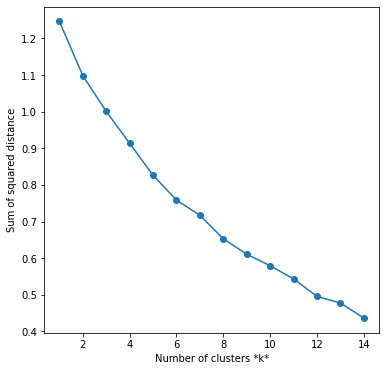

In [91]:
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(df_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.savefig('elbow.png',dpi=300)
plt.show()

The plot is monotonically decreasing and does not show any elbow or has an obvious point where the curve starts flattening out. Thus it is still hard to figure out a good number of clusters to use.

## Silhouette Analysis
Silhouette analysis can be used to determine the degree of separation between clusters. For each sample:
- Compute the average distance from all data points in the same cluster (ai).
- Compute the average distance from all data points in the closest cluster (bi).
- Compute the coefficient:
(bi-ai)/max(ai,bi)

The coefficient can take values in the interval [-1, 1].
- If it is 0 –> the sample is very close to the neighboring clusters.
- If it is 1 –> the sample is far away from the neighboring clusters.
- If it is -1 –> the sample is assigned to the wrong clusters.
Therefore, we want the coefficients to be as big as possible and close to 1 to have a good clusters.

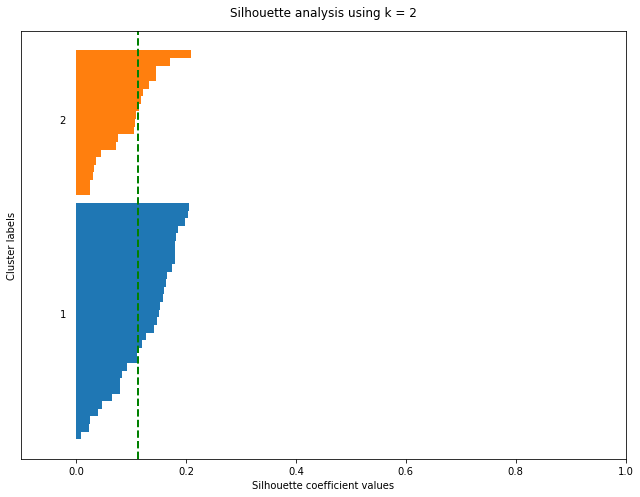

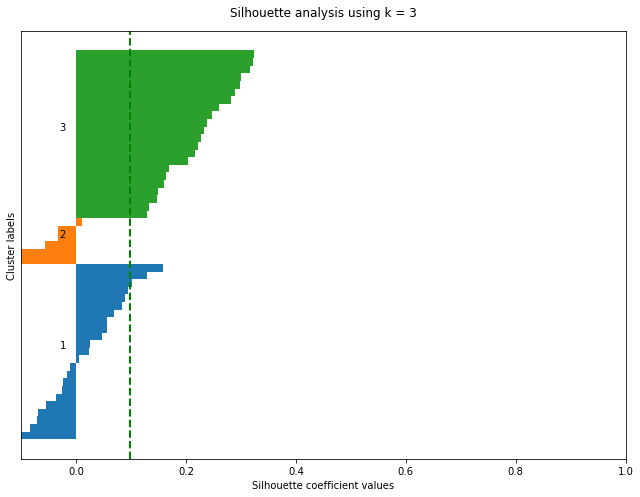

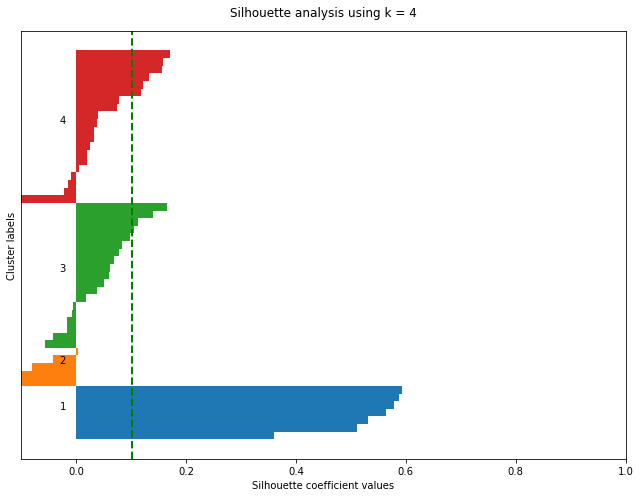

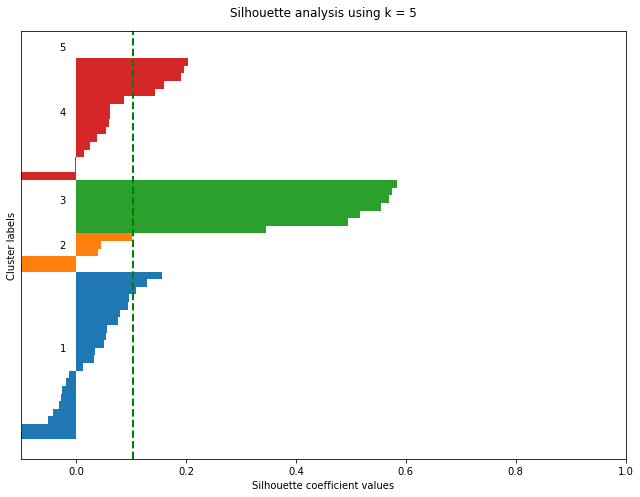

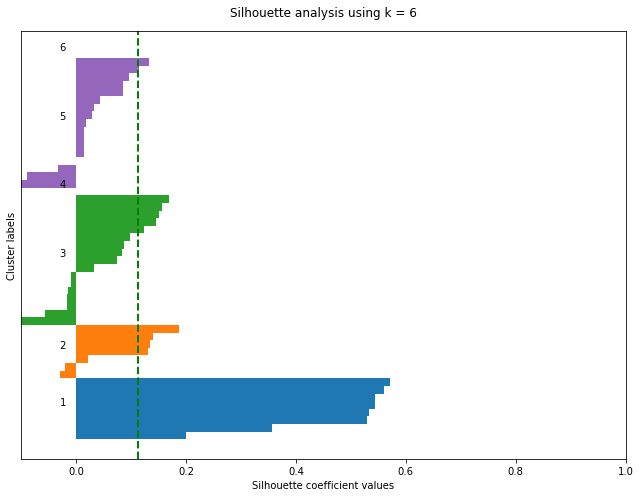

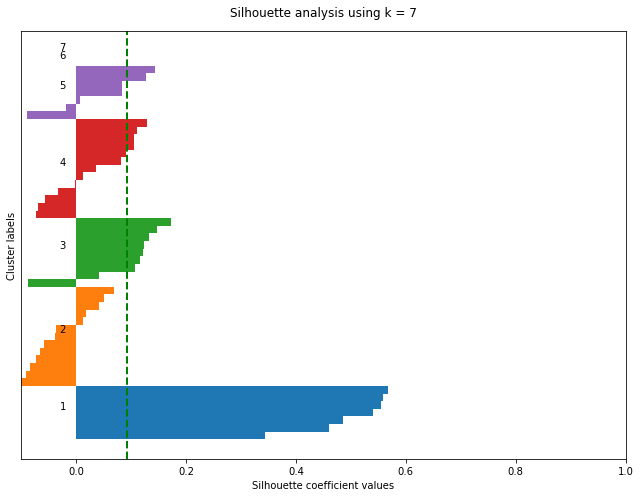

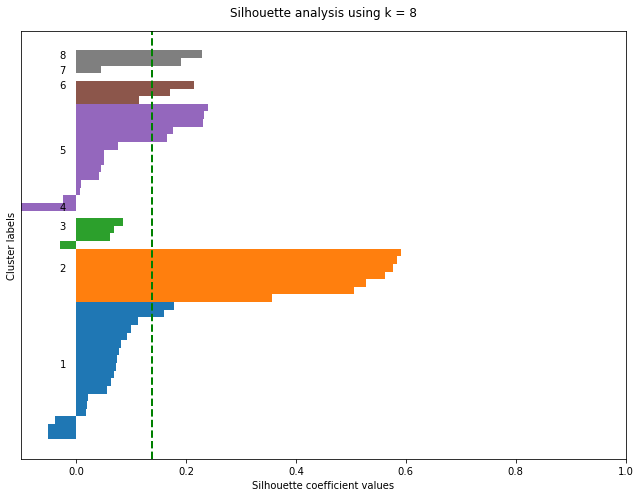

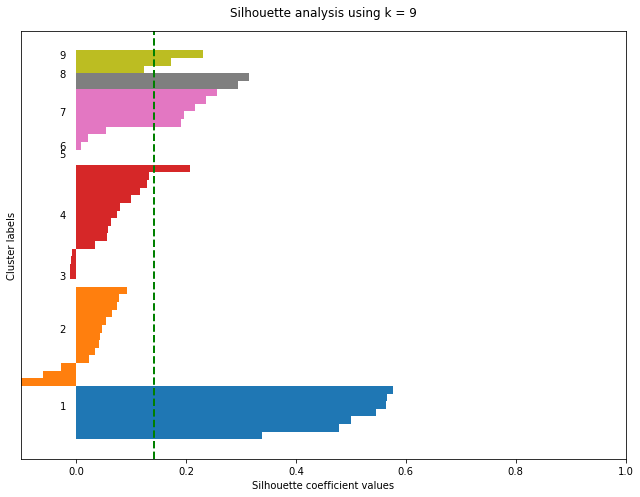

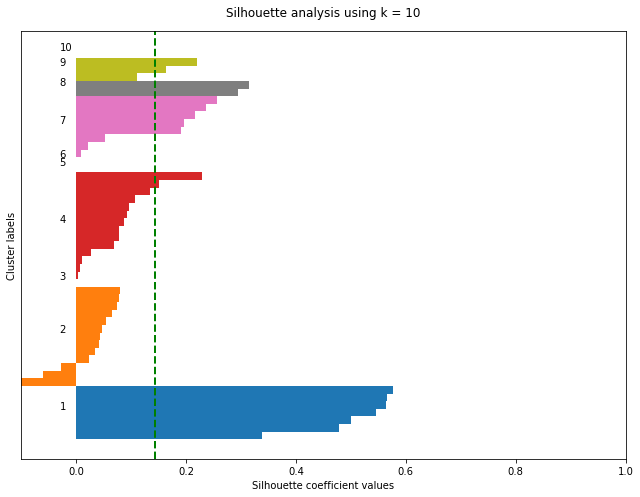

In [126]:
#pp = PdfPages('sil.pdf')

for i, k in enumerate([2, 3, 4, 5, 6, 7, 8, 9, 10]):
#for i, k in enumerate([5]):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(df_grouped_clustering)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(df_grouped_clustering, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title(f'Silhouette analysis using k = {k}', y=1.02);
    plt.tight_layout()
    #pp.savefig(fig)

#pp.close()
#plt.savefig(f'sil_{k}')
    # Scatter plot of data colored with labels
#     ax2.scatter(df_grouped_clustering[:, 0], df_grouped_clustering[:, 1], c=labels)
#     ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
#     ax2.set_xlim([-2, 2])
#     ax2.set_xlim([-2, 2])
#     ax2.set_xlabel('Eruption time in mins')
#     ax2.set_ylabel('Waiting time to next eruption')
#     ax2.set_title('Visualization of clustered data', y=1.02)
#     ax2.set_aspect('equal')
#     plt.tight_layout()
#     plt.suptitle(f'Silhouette analysis using k = {k}',
#                  fontsize=16, fontweight='semibold', y=1.05);

As the above plots show, changing k from 2 to 10 does not change average silhouette score significantly. k=5 is sufficiate for our purposes. 

# Model Deployment
Once the model is evaluated and the data scientist is confident it will work, it is deployed and put to the ultimate test.

# Feedback
Once in play, feedback from the users will help to refine the model and assess it for performance and impact.